   # Extending Single Domain Approach: the effect of interactions

## Here it will be implemented 'my approach' to include interactions in the free energy density within the Stoner-Wohlfarth (single-domain) framework. It will be addressed magnetic interactions, such as dipole-dipole, exchange and dzyaloshinskii-moriya to calculate magnetization curves. Basically, for a given particle 'j' of the array in the step 'k' of the hysteresis procedure, the magnetization value ( described by $(\theta_j,\phi_j)$) of its neighbors will be approximated by its value in the step 'k-1'th (previous computation of the magnetic moments orientation). In this way, starting from technical saturation at high fields, the magnetization angles of the whole array can be calculated through common energy minimization procedures. The approach succeeds when the field-step is small enough to assure convergence of the calculations.

In [1]:
# the necessary import statements!

# to paralelize and accelerate the calculations
import numba as nb
from numba import jit
from numba import njit


import joblib
from joblib import Parallel, delayed
import multiprocessing


# numpy for fast calculations using arrays
import numpy as np

# scipy for minimization
import scipy
from scipy import optimize
from scipy.optimize import minimize as spmin
from scipy.optimize import Bounds

# some trigonometric functions
from math import pi, sin, cos, sqrt
import math

# to plot graphics
import matplotlib.pyplot as plt
%matplotlib inline

# the time of some calculations
import timeit

import dlib

import random

from tqdm import tnrange, tqdm_notebook

In [3]:
#from numba import numba_scipy

In [1063]:
# parameters of the simulation

Msat=float(1000/(4*pi))
Ms=float(1/Msat)

#K1=float(((1*1.00)*10**4))
K1=float(((-0*6.00)*10**4))
K2=float((-0*0.05*10**5))
Kuni=float((0*0.6*10**4))
Kuni2=float((0*0.5*10**4))
K1mel=float((0*0.5*10**4))
K1out=float((0*2.0*10**4))
Knucl=float((0*1.0*10**4))

# EB parameters!
Kf1=float(((1*3.000)*10**2))
Kf1_bi=float(((0*2.000)*10**2))
tf=10.*10**-9
Jeff_EB=float(((1*0.0030/tf)*10**-3))/(Msat**2)
#Jeff_EB=float(((0*0.000010/tf)*10**-3))/(Msat**2)
Jeff_C =float(((1*0.0030/tf)*10**-3))/(Msat**2)
Jeff_C_quad=float(((0*0.0030/tf)*10**-3))/(Msat**2)

gamma_f = 0*3.1415/4.+1*pi/180.
phi_eb = 1*3.1415/180.
theta_eb = 3.1415/2.+1*pi/180.
thetarma = 3.1415/2.+1*pi/180.
tau_avg = 4000*10**-6
tempo = 1000*tau_avg

Neff=float(1.00*1.000)
#field-dependent anisotropy
Kfd=float(-0*0.30*10**0)
#Krot=float((1*2.50*10**4))
Krot=float((-0*1.65*10**4))
Krot2=float((-0*1.80*10**3))
htheta=float(+2*pi/4.+1.00*pi/180.)
hphi=float(0*pi/4+5.00*pi/180.)

# Nanoparticle arrangement order
# 1-> square
# 2-> ring
# 3-> nanomembrane
np_order = 1


Nparticles=10

height=1

NN=Nparticles**3
NN2=Nparticles**2

NN2=2

# interaction strengths!

m = -0*0.008

beta = 0*0.002

jota = -0*0.004

jotabi = -0*0.04



In [1064]:
tempo-tau_avg,tempo

(3.996, 4.0)

In [1065]:
Jeff_C,Jeff_EB,Kf1/Msat**2,Jeff_C_quad

(0.04737410112522892, 0.04737410112522892, 0.04737410112522892, 0.0)

In [1066]:
Jeff_EB/(Kf1/Msat**2)

1.0

In [1067]:
Jeff_C/(Kf1/Msat**2)

1.0

In [1068]:
Jeff_C_quad/(Kf1/Msat**2)

0.0

In [1069]:
beta/(Kf1/Msat**2)

0.0

In [1070]:
np.arccos(1/3.),np.arccos(1/1.71)

(1.2309594173407747, 0.9461686134701807)

In [1071]:
htheta

1.5882496193148399

In [1072]:
print(beta,Krot/Msat**2,m,K1/Msat**2,Kuni)

0.0 0.0 0.0 0.0 0.0


In [1219]:
# applied field parameters

hini=36.400*1
hfinal=-36.400*1
step=600*8
stepmag=0.15/step
stepmag=0.00/step
hpasso=(hfinal-hini)/step
print(K1,K2,Krot,Msat,step)

0.0 0.0 0.0 79.57747154594767 4800


In [1220]:
gamma_f,thetarma

(0.017453292519943295, 1.5882032925199434)

In [1221]:
# array for angle dispersion in 'phi' and 'theta'

phi_np = np.array([0*random.random() for x in range(NN2)],dtype=np.float64)
theta_np = np.array([0*random.random() for x in range(NN2)],dtype=np.float64)
#print(phi_np)

In [1222]:
# the function that defines the common magnetic anisotropy terms
#@jit(nopython=True)
@jit(nopython=True,parallel=True)
#def anisotropy(phi,theta,K1,K2,h,htheta,hphi,Msat,i):
def anisotropy(phi,theta,K1,K2,h,htheta,hphi,Msat,i,phiantarray,thetaantarray):

    phiant=phiantarray[i]
    thetaant=thetaantarray[i]

#    anis+=Kuni/(Msat**2)*np.sin(phi-3.1415/4.)**2*np.sin(theta-3.1415/4.)**2
#    anis=Kuni/(Msat**2)*np.sin(phi-3.1415/4.)**2*np.sin(theta-0.94)**2

    anis=Kuni/(Msat**2)*np.cos(phi-3.1415/4.)**2*np.sin(phi-3.1415/4.)**2*np.sin(theta)**2
#    anis=Kuni/(Msat**2)*(np.sin(phi-phi_np[i])**2*np.cos(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**4+np.sin(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**2*np.cos(theta-theta_np[i])**2+np.cos(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**2*np.cos(theta-theta_np[i])**2)
#    anis=Kuni/(Msat**2)*(np.sin(phi-phi_np[i])**2*np.cos(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**4)
    
#    theta=theta+0.97
#    phi=phi-3.1415/4.

    
# first-order cubic magnetocrystalline anisotropy
#    anis=K1/(Msat**2)*(np.sin(phi-3.14/4.)**2*np.cos(phi-3.14/4.)**2*np.sin(theta-0.94)**4+np.sin(phi-3.14/4.)**2*np.sin(theta-0.94)**2*np.cos(theta-0.94)**2+np.cos(phi-3.14/4.)**2*np.sin(theta-0.94)**2*np.cos(theta-0.94)**2)
#    anis=K1/(Msat**2)*(np.sin(phi-3.14/4.)**2*np.cos(phi-3.14/4.)**2*np.sin(theta)**4+np.sin(phi-3.14/4.)**2*np.sin(theta)**2*np.cos(theta)**2+np.cos(phi-3.14/4.)**2*np.sin(theta)**2*np.cos(theta)**2)
    anis+=K1/(Msat**2)*(np.sin(phi-phi_np[i])**2*np.cos(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**4+np.sin(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**2*np.cos(theta-theta_np[i])**2+np.cos(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**2*np.cos(theta-theta_np[i])**2)

# second-order cubic magnetocrystalline anisotropy    
    anis+=K2/(Msat**2)*np.sin(phi)**2*np.sin(theta)**2*np.cos(phi)**2*np.sin(theta)**2*np.cos(theta)**2

# Eb anisotropy terms!

    anis+= (Kf1/(Msat**2))*(np.sin(phi-gamma_f)**2)*(np.sin(theta)**2)
    
    anis+= Kf1_bi/(Msat**2)*np.sin(phi-gamma_f)**2*np.cos(phi-gamma_f)**2*np.sin(theta)**2
    
    anis+=-Jeff_EB*(np.sin(theta)*np.sin(theta_eb)*np.cos(phi-phi_eb)+np.cos(theta)*np.cos(theta_eb))

#    thetarma = 3.1415/2.
    thetarma = theta*tempo
#    phi_rma=phi*(tempo-tau_avg)
    phi_rma=phi*(tempo)
    
    
#    anis += -Jeff_C*(np.sin(theta)*np.sin(thetarma)*np.cos(phi-phi_rma)+np.cos(theta)*np.cos(thetarma))
#    anis += -Jeff_C_quad*(np.sin(theta)*np.sin(thetarma)*np.cos(phi-phi_rma)+np.cos(theta)*np.cos(thetarma))**2
    
#    anis += -Jeff_C*(np.cos(phi-phi_rma))
#    anis += -Jeff_C_quad*(np.cos(phi-phi_rma))**2

    anis += -Jeff_C*(np.cos(phi-phi_rma)*np.sin(theta-thetarma))
    anis += -Jeff_C_quad*(np.cos(phi-phi_rma)*np.sin(theta-thetarma))**2
    
    # demagnetizing energy
    anis+=2*3.1415*Neff/(Msat**2)*np.cos(theta)**2

    anis+=Knucl/(Msat**2)*np.sin(theta-thetaant)*np.cos(phi-phiant)**1
    
    anis+=K1out/(Msat**2)*np.cos(theta)**2

    
    # magelas anisotropy 
    
#    anis+=K1mel/(Msat**2)*np.cos(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**2
#    anis+=K1mel/(Msat**2)*np.cos(theta)**2
    anis+=K1mel/(Msat**2)*np.cos(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**2
    
    
# uniaxial anisotropy 
    
    
# uniaxial anisotropy 
    
    anis+=Kuni2/(Msat**2)*np.sin(phi-3.1415/4.)**4*np.sin(theta-0.94)**4

# field dependent anis!

#    anis+=Kfd/(Msat**2)*h*Msat*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))
    anis+=Kfd/(Msat**2)*h*Msat**2*(np.sin(theta)*np.cos(phi-3.1415/4.))**2
    
# rotatable anis!

#    anis+=Krot/(Msat**2)*(h*Msat)**1*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))**1
    anis+=Krot/(Msat**2)*(np.sin(htheta)*np.sin(theta-theta_np[i])*np.cos(phi-phi_np[i]-hphi)+np.cos(htheta)*np.cos(theta-theta_np[i]))**2
    

    """
    if(abs(h*Msat)>100):
    
        anis+=0*Krot/(Msat**2)*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))**2
    else:
        anis+=(100-abs(h*Msat))/100.*Krot/(Msat**2)*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))**2
    """
    
    anis+=Krot2/(Msat**2)*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))**4
    
#    print(Kf1_bi/(Msat**2),anis,gamma_f)
    
    return anis
    

In [1223]:
anisotropy(3.1415/4.,3.1415/2.,K1,K2,h,htheta,hphi,Msat,0,phiantarray,thetaantarray)

/home/vagner/anaconda3/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-1222-ea666ca6a52e>", line 4:
@jit(nopython=True,parallel=True)
#def anisotropy(phi,theta,K1,K2,h,htheta,hphi,Msat,i):
^

  state.func_ir.loc))


0.022281886944423672

In [1224]:
# Zeeman Energy

#@jit(nopython=True)
@jit(nopython=True,parallel=True)
def zeeman_energy(phi,theta,K1,K2,h,htheta,hphi,Msat,i):
    

    zeeman=-h*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))


    return zeeman


In [1225]:
# creating positions!
# this is for creating positions!

#@jit(nopython=True,parallel=True)
#@jit(nopython=True)
def create_pos(np_order,NN2):
    
    if(np_order==1):
        
        nnx=int(sqrt(NN2))
        nny=int(sqrt(NN2))
        
        coord_pos = []
#        coord_pos = np.zeros((nnx,nny,nnx))
#        coord_pos = np.zeros(NN2)
        
        for i in range(nnx):

            for j in range(nnx):
                
#                coord_pos.append([i,j,0])
                coord_pos.append([1*i,1*j,0])
#                coord_pos = np.append(coord_pos,[1*i,1*j,0])

#                coord_pos[i][j][0] = np.array([1*i,1*j,0])
    
    elif(np_order==2):
        
        coord_pos=[]
        
        for i in range(NN2):
            
            coord_pos.append([NN2*math.cos(2*pi*i/NN2),NN2*math.sin(2*pi*i/NN2),0])
    
    elif(np_order==3):
        
        coord_pos=[]
        
        for j in range(height):
        
            for i in range(NN2):

                coord_pos.append([NN2*math.cos(2*pi*i/NN2),j,NN2*math.sin(2*pi*i/NN2)])

    return np.array(coord_pos,dtype=np.float64)


In [1226]:
# this is to create the angles, which are used in the computation of the interactions!

ar_pos=create_pos(np_order,NN2)


#@jit(nopython=True,parallel=True)
@jit(nopython=True)
def angles_vecs(NN2):

    print(np_order)
#    ar_pos=create_pos(np_order,NN2)

#    print(ar_pos)
    
    x_coord = [ar_pos[i][0] for i in range(NN2*height)]
    y_coord = [ar_pos[i][1] for i in range(NN2*height)]
    z_coord = [ar_pos[i][2] for i in range(NN2*height)]

    x_ang = []
    y_ang = []
    
    for i in range(NN2*height):
        x_ang_menor=[]
        y_ang_menor=[]
        
        for j in range(NN2*height):
            
            if(i!=j):
                innerproduct = x_coord[i]*x_coord[j]+y_coord[i]*y_coord[j]

                dist1 = sqrt(x_coord[i]**2+y_coord[i]**2+z_coord[i]**2)
                dist2 = sqrt(x_coord[j]**2+y_coord[j]**2+z_coord[j]**2)
                
                distnewvec = sqrt((x_coord[j]-x_coord[i])**2+(y_coord[j]-y_coord[i])**2+(z_coord[j]-z_coord[i])**2)
                distnewvecplane = sqrt((x_coord[j]-x_coord[i])**2+(y_coord[j]-y_coord[i])**2)
                
                if(distnewvecplane!=0.0):
#                    angphi = math.acos((x_coord[j]-x_coord[i])/distnewvecplane)
#                    angtheta = math.acos((z_coord[j]-z_coord[i])/distnewvec)
                    angphi = math.acos((x_coord[i]-x_coord[j])/distnewvecplane)
                    angtheta = math.acos((z_coord[i]-z_coord[j])/distnewvec)
                elif(distnewvecplane == 0.0):
                    angphi = 0.0
                    angtheta = 3.1415/2.
                x_ang_menor.append(angphi)
                y_ang_menor.append(angtheta)
                
            elif(i==j):
                
                x_ang_menor.append(0.0)
                y_ang_menor.append(0.0)
                
        x_ang.append(x_ang_menor)
        y_ang.append(y_ang_menor)
        x_ang_menor=[]
        y_ang_menor=[]
                

                
#    return np.array(x_ang,dtype=np.float64),np.array(y_ang,np.float64)
#    return np.array(x_ang),np.array(y_ang)
    return x_ang,y_ang

In [1227]:
# Function to calculate the distance between particles 'i' and 'j'

#@jit(nopython=True)
def dist_dipolar(i,j):
    sizex=int(sqrt(NN2))
    sizey=int(sqrt(NN2))
    
    # distance of particle 'j' from particle 'i'
#    distdip=[]
    '''
    for ii in range(sizex):
        for jj in range(sizey):
            distdip.append(sqrt((int(i/sizex)-ii)**2+(int(i%sizey)-jj)**2))
    '''
    
    '''
    distdip=sqrt((int(i/sizex)-int(j/sizex))**2+(int(i%sizey)-int(j%sizey))**2)
    '''

    if(np_order==1):

        distdip=[]
        for ii in range(NN2):
            distdip1=[]
            for jj in range(NN2):
                distdip1.append(sqrt((int(ii/sizex)-int(jj/sizex))**2+(int(ii%sizey)-int(jj%sizey))**2))
            distdip.append(distdip1)
            
    elif(np_order==2):
        
        distdip=[]
#        distdip=np.empty(NN2)
        for ii in range(NN2):
            distmin=[]
            distdip1=[]
            for jj in range(NN2):
                distdip1.append(sqrt((math.cos(2*pi*ii/NN2)-math.cos(2*pi*jj/NN2))**2+(math.sin(2*pi*ii/NN2)-math.sin(2*pi*jj/NN2))**2))
            
                if(ii!=jj):
                    distmin.append(sqrt((math.cos(2*pi*ii/NN2)-math.cos(2*pi*jj/NN2))**2+(math.sin(2*pi*ii/NN2)-math.sin(2*pi*jj/NN2))**2))

            arraydistmin=np.array(distmin)
            
            distdip1new=[]
            
            for u in range(NN2):
                distdip1new.append(distdip1[u]/np.amin(arraydistmin))
            
            distdip.append(distdip1new)
#            distdip1=np.array(distdip1)
#            distmin=np.array(distmin)
#            distdip[ii]=distdip1/np.amin(distmin)
#            distdip=np.array(distdip)


    elif(np_order==3):
        
        distdip=[]
#        distdip=np.empty(NN2)
        for ii in range(NN2*height):
            distmin=[]
            distdip1=[]
            for jj in range(NN2*height):
#                for kkk in range(height):
#                    for kk in range(height):
           
                distdip1.append(sqrt((math.cos(2*pi*(ii%NN2)/NN2)-math.cos(2*pi*(jj%NN2)/NN2))**2+(math.sin(2*pi*(ii%NN2)/NN2)-math.sin(2*pi*(jj%NN2)/NN2))**2+((int(ii/NN2)-int(jj/NN2))/height)**2))

                if(ii!=jj):
                
                    distmin.append(sqrt((math.cos(2*pi*(ii%NN2)/NN2)-math.cos(2*pi*(jj%NN2)/NN2))**2+(math.sin(2*pi*(ii%NN2)/NN2)-math.sin(2*pi*(jj%NN2)/NN2))**2+((int(ii/NN2)-int(jj/NN2))/height)**2))

            arraydistmin=np.array(distmin)

            distdip1new=[]
            if(np.amin(arraydistmin)==0.0):
                print(ii,'ii')
                print(distdip1[1])
                print('zerou',np.argmin(arraydistmin),arraydistmin[np.argmin(arraydistmin)-1])
                break

            for u in range(NN2*height):
                distdip1new.append(distdip1[u]/np.amin(arraydistmin))

            distdip.append(distdip1new)



#        distdip=[]
        
#    return np.array(distdip,dtype=np.float64)
#    return distdip[j]
    return distdip


In [1228]:
ii=20
jj=30
print(len(dist_dipolar(2,3)))
#dist_dipolar(20,30)[14][25]

2


In [1229]:
sqrt((10%height/height)**2)
(((0%height)-(int(320/height)))/height)**2

102400.0

In [1230]:
math.cos(2*pi*(64%NN2)/NN2)

1.0

In [1231]:
dd=np.zeros((9),dtype=np.object)
print(dd[2])
dd[1]=np.array((1,2))
print(dd)

0
[0 array([1, 2]) 0 0 0 0 0 0 0]


In [1232]:
print(10%int(sqrt(NN2)),10/int(sqrt(NN2)))
print(int(sqrt(NN2)))

0 10.0
1


In [1233]:
vec_dip=np.array(dist_dipolar(20,30))

In [1234]:
len(vec_dip[1])

2

In [1235]:
import itertools

In [1236]:
x_ang,y_ang = angles_vecs(NN2)
#rr=dist_dipolar(i)
x_ang=np.array(x_ang,dtype=np.float64)
y_ang=np.array(y_ang,dtype=np.float64)

1


In [1237]:
len(x_ang[1])

2

In [1238]:
y_ang[1]

array([1.57075, 0.     ])

In [1239]:
# the interactions
#vec_dip_called = np.array(vec_dip)

#@jit(nopython=True)
@jit(nopython=True,parallel=True,fastmath=True)
def energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):

    #obtaining the angles to calculate the interactions!

#    print(i,'i before')
#    print(j,'j before')
    
#    x_ang,y_ang = angles_vecs(NN2)
#    print(i,'i')
#    print(j,'j')
#    print(phiantarray)
    phiant = phiantarray[j]
    thetaant = thetaantarray[j]
# dipolar energy

#    phiant=phi+phiantarray[j]-phiantarray[i]
#    thetaant=theta+thetaantarray[j]-thetaantarray[i]

#    print(beta,'beta')

    rr=vec_dip[i][j]
#    rr=vec_dip_called[i][j]

#    create_pos(np_order,NN2)
    inter_dipolar=-3*beta/(rr**3)*(np.sin(theta)*np.sin(y_ang[i][j])*np.cos(phi-x_ang[i][j])+np.cos(theta)*np.cos(y_ang[i][j]))*(np.sin(thetaant)*np.sin(y_ang[i][j])*np.cos(phiant-x_ang[i][j])+np.cos(thetaant)*np.cos(y_ang[i][j]));
    inter_dipolar+=beta/(rr**3)*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant))

#    print(inter_dipolar,'dipolar')
    
    return inter_dipolar
    
# exchange energy

# moriya energy



In [1240]:
energy_interdipolar(0.2,0.5,phiantarray,thetaantarray,K1,K2,0.3,htheta,hphi,0,1)

/home/vagner/anaconda3/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-1239-83dfadcaca31>", line 6:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
^

  state.func_ir.loc))


0.0

In [1241]:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_interexchange(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
    #obtaining the angles to calculate the interactions!

#    print(i,'i before')
#    print(j,'j before')
    
#    x_ang,y_ang = angles_vecs(NN2)
#    print(i,'i')
#    print(j,'j')
#    print(phiantarray)
    phiant = phiantarray[j]
    thetaant = thetaantarray[j]
# dipolar energy

#    phiant=phi+phiantarray[j]-phiantarray[i]
#    thetaant=theta+thetaantarray[j]-thetaantarray[i]

#    print(beta,'beta')

    rr=vec_dip[i][j]
#    rr=vec_dip_called[i][j]

#    create_pos(np_order,NN2)
    inter_exc=jota*np.exp(-rr**9)/np.exp(-1.0)*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant))
#    print(jota*np.exp(-rr)/np.exp(-1.0))
#    print((np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant)))

#    print(inter_dipolar,'dipolar')
    
    return inter_exc


In [1242]:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_interexchange_eb(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
    #obtaining the angles to calculate the interactions!

#    print(i,'i before')
#    print(j,'j before')
    
#    x_ang,y_ang = angles_vecs(NN2)
#    print(i,'i')
#    print(j,'j')
#    print(phiantarray)
    phiant = phiantarray[j]
    thetaant = thetaantarray[j]
# dipolar energy

#    phiant=phi+phiantarray[j]-phiantarray[i]
#    thetaant=theta+thetaantarray[j]-thetaantarray[i]

#    print(beta,'beta')

    rr=vec_dip[i][j]
#    rr=vec_dip_called[i][j]

#    create_pos(np_order,NN2)
    inter_exc= -0*Jeff_EB*np.exp(-rr**9)/np.exp(-1.0)*(np.sin(theta)*np.sin(theta_eb)*np.cos(phi-phi_eb)+np.cos(theta)*np.cos(theta_eb))
#    print(jota*np.exp(-rr)/np.exp(-1.0))
#    print((np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant)))

#    print(inter_dipolar,'dipolar')
    
    return inter_exc


In [1243]:
Jeff_EB,phi_eb

(0.04737410112522892, 0.01745277777777778)

In [1244]:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_interexchange_rma(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
    #obtaining the angles to calculate the interactions!

#    print(i,'i before')
#    print(j,'j before')
    
#    x_ang,y_ang = angles_vecs(NN2)
#    print(i,'i')
#    print(j,'j')
#    print(phiantarray)
    phiant = phiantarray[j]
    thetaant = thetaantarray[j]
# dipolar energy

#    phiant=phi+phiantarray[j]-phiantarray[i]
#    thetaant=theta+thetaantarray[j]-thetaantarray[i]

#    print(beta,'beta')

    rr=vec_dip[i][j]
#    rr=vec_dip_called[i][j]

#    create_pos(np_order,NN2)
#    theta_rma = theta*(tempo-tau_avg)
    thetarma = 3.1415/2.
#    theta_rma = theta
    phi_rma=phi*(tempo-tau_avg)
    inter_exc = -0*Jeff_C*np.exp(-rr**9)/np.exp(-1.0)*(np.sin(theta)*np.sin(thetarma)*np.cos(phi-phi_rma)+np.cos(theta)*np.cos(thetarma))
    inter_exc += -0*Jeff_C_quad*np.exp(-rr**9)/np.exp(-1.0)*(np.sin(theta)*np.sin(thetarma)*np.cos(phi-phi_rma)+np.cos(theta)*np.cos(thetarma))**2
#    print(jota*np.exp(-rr)/np.exp(-1.0))
#    print((np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant)))

#    print(inter_dipolar,'dipolar')
    
    return inter_exc


In [1245]:
phi_eb,tau_avg

(0.01745277777777778, 0.004)

In [1246]:
Jeff_C/(Kf1/Msat**2),Jeff_C_quad/(Kf1/Msat**2)

(1.0, 0.0)

In [1247]:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_biinterexchange(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
    #obtaining the angles to calculate the interactions!

#    print(i,'i before')
#    print(j,'j before')
    
#    x_ang,y_ang = angles_vecs(NN2)
#    print(i,'i')
#    print(j,'j')
#    print(phiantarray)
    phiant = phiantarray[j]
    thetaant = thetaantarray[j]
# dipolar energy

#    phiant=phi+phiantarray[j]-phiantarray[i]
#    thetaant=theta+thetaantarray[j]-thetaantarray[i]

#    print(beta,'beta')

    rr=vec_dip[i][j]
#    rr=vec_dip_called[i][j]

#    create_pos(np_order,NN2)
    inter_excbi=jotabi*np.exp(-rr**9)/np.exp(-1.0)*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant))**2
#    print(jota*np.exp(-rr)/np.exp(-1.0))
#    print((np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant)))

#    print(inter_dipolar,'dipolar')
    
    return inter_excbi


In [1248]:
# the interactions
#vec_dip_called = np.array(vec_dip)

#@jit(nopython=True)
@jit(nopython=True,parallel=True,fastmath=True)
def energy_moriya(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):

    #obtaining the angles to calculate the interactions!

#    print(i,'i before')
#    print(j,'j before')
    
#    x_ang,y_ang = angles_vecs(NN2)
#    print(i,'i')
#    print(j,'j')
#    print(phiantarray)
    phiant = phiantarray[j]
    thetaant = thetaantarray[j]
# dipolar energy

#    phiant=phi+phiantarray[j]-phiantarray[i]
#    thetaant=theta+thetaantarray[j]-thetaantarray[i]

#    print(beta,'beta')

    rr=vec_dip[i][j]
#    rr=vec_dip_called[i][j]

#    create_pos(np_order,NN2)

#   vectorial product with k^ versor !

    if(i<=j):
        if(j==i+1):
            ## produto vetorial z^ vec x^ = y^!
#            inter_moriya=m*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta));

#            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta));
#            inter_moriya+=-m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant));
        
            # biquadratic
#            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta))**2;
#            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant))**2;
#            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.sin(thetaant)*np.cos(phiant)*np.sin(theta)*np.sin(phi)-np.sin(theta)*np.cos(phi)*np.sin(thetaant)*np.sin(phiant))**2;
        
            # chiral multi spin
            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta))*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant));
            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant))*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant));
            
        else:
            ## produto vetorial z^ vec y^ = - x^!
#            inter_moriya=-m*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant));

#            inter_moriya=-m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant));
#            inter_moriya+=+m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta));
        
            # biquadratic
#            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant))**2;
#            inter_moriya+=+m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta))**2;
#            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.sin(thetaant)*np.cos(phiant)*np.sin(theta)*np.sin(phi)-np.sin(theta)*np.cos(phi)*np.sin(thetaant)*np.sin(phiant))**2;
        
        
            # chiral multi spin
            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta))*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant));
            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant))*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant));
        
    elif(i>=j):
        if(j==i-1):
#            inter_moriya=-m*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta));

#            inter_moriya=-m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta));
#            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant));
        
            # biquadratic
#            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta))**2;
#            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant))**2;
#            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.sin(thetaant)*np.cos(phiant)*np.sin(theta)*np.sin(phi)-np.sin(theta)*np.cos(phi)*np.sin(thetaant)*np.sin(phiant))**2;
        
            # chiral multi spin
            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta))*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant));
            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant))*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant));
            
        else:
#            inter_moriya=m*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant));

#            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant));
#            inter_moriya+=-m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta));
            
            # biquadratic
#            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant))**2;
#            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta))**2;
#            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.sin(thetaant)*np.cos(phiant)*np.sin(theta)*np.sin(phi)-np.sin(theta)*np.cos(phi)*np.sin(thetaant)*np.sin(phiant))**2;
            
            # chiral multi spin
            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta))*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant));
            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant))*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant));

#            inter_moriya=-m*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant));


#    inter_moriya=m*np.exp(-rr**3)/np.exp(-1.0)*(np.cos(phi)*np.sin(phiant)*np.sin(theta)*np.sin(thetaant)-np.cos(phiant)*np.sin(phi)*np.sin(theta)*np.sin(thetaant));
#    inter_moriya=m*np.exp(-rr**9)/np.exp(-1.0)*(np.sin(theta)*np.sin(thetaant)*np.sin(phi-phiant));

    

    
#    inter_moriya+=beta/(rr**3)*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant))

#    print(m,'dipolar')
    
    return inter_moriya
    
# exchange energy

# moriya energy



In [1249]:
energy_moriya(1.0,3.0,phiantarray,thetaantarray,K1,K2,0.3,htheta,hphi,11,10)

/home/vagner/anaconda3/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-1248-5e99dc2a3568>", line 6:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_moriya(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
^

  state.func_ir.loc))


0.0

In [1250]:
np.exp(-1.0),vec_dip[1]

(0.36787944117144233, array([1., 0.]))

In [1251]:
energy_interexchange(0.0,0.0,phiantarray,thetaantarray,K1,K2,0.3,htheta,hphi,4,5)

/home/vagner/anaconda3/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-1241-ced6ec3e3998>", line 2:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_interexchange(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
^

  state.func_ir.loc))


0.0

In [1252]:
energy_biinterexchange(0.0,0.0,phiantarray,thetaantarray,K1,K2,0.3,htheta,hphi,4,5)

/home/vagner/anaconda3/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-1247-c27d49cfb87b>", line 2:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_biinterexchange(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
^

  state.func_ir.loc))


0.0

In [1253]:
# energy array

#@jit(nopython=True,parallel=True)
#@jit(nopython=True)
#@njit(fastmath=True,parallel=True)
@njit(fastmath=True)
def energy_array_inter(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):

    '''
    
    listaNN1=[0. for x in range(int(sqrt(NN2))-2)]
    
    for x in range(0,int(sqrt(NN2))-2):
        listaNN1[x] = int(sqrt(NN2))-x-2
                                
    listaNN2=[0. for x in range(int(sqrt(NN2))-2)]
    
    for x in range(0,int(sqrt(NN2))-2):
        listaNN2[x] = int(sqrt(NN2))*(x+2)-1
                                
    listaNN3=[0. for x in range(int(sqrt(NN2))-2)]
    
    for x in range(0,int(sqrt(NN2))-2):
        listaNN3[x] = NN2-x-2
    
    listaNN4=[0. for x in range(int(sqrt(NN2))-2)]
    
    for x in range(0,int(sqrt(NN2))-2):
        listaNN4[x] = int(sqrt(NN2))*(x+1)

#    print('listas',listaNN1,listaNN2,listaNN3,listaNN4)

    """
    for x in range(NN2):
        
        x=i
        for y in range(int(sqrt(NN2))-2):
            
            print(listaNN3[y]==x)
#            print(x,y,'xy')
                                
            if(listaNN1[y]==x):
                                
                foi=-1
                                
            elif(listaNN2[y]==x):
                                
                foi=-2
#                print(foi,'foi dentro',listaNN3[y],x)
                                
            elif(listaNN3[y]==x):
                                
                foi=-3
#                print(foi,'foi dentro',listaNN3[y],x)
                                
            elif(listaNN4[y]==x):
                                
                foi=-4
            else:
                                
                foi=-5
#            print(foi,'foi dentro',listaNN3[y],x)
    """                         

    
        
    x=i
    for y in range(int(sqrt(NN2))-2):
            
#        print(listaNN3[y]==x)
#            print(x,y,'xy')
                                
        if(listaNN1[y]==x):
                                
            foi=-1
            break
                                
        elif(listaNN2[y]==x):
                                
            foi=-2
#                print(foi,'foi dentro',listaNN3[y],x)
            break
                                
        elif(listaNN3[y]==x):
                                
            foi=-3
            break
#                print(foi,'foi dentro',listaNN3[y],x)
                                
        elif(listaNN4[y]==x):
                                
            foi=-4
            break
        else:
                                
            foi=-5
#            print(foi,'foi dentro',listaNN3[y],x)
    
    
    
#    print(foi,'foi fora')
                                
#    print(i,j)
    
    # defining the energy array!
    energy_vec=[0.0 for x in range(NN2)]
    
    
    if(np_order==1):
        
        if(i==0):
        
            dip_b=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,0,1)
            dip_b+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,0,int(sqrt(NN2)))
            dip_b+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,0,int(sqrt(NN2))-1)
            dip_b+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,0,NN2-int(sqrt(NN2)))
            
            
            energy_vec[i]=dip_b

    
        elif(foi==-1):
                
                
#            print(i,'i dentro de foi=-1')
            
            dip_f=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-1)
            dip_f+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+1)
            dip_f+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+int(sqrt(NN2)))
            dip_f+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,NN2-int(sqrt(NN2))+i)
            
#            print(dip_f,'dip_f')
    
            energy_vec[i]=dip_f

        elif(i==int(sqrt(NN2)-1)):
                                
            dip_c=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,int(sqrt(NN2))-1,int(sqrt(NN2))-2)
            dip_c+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,int(sqrt(NN2))-1,2*int(sqrt(NN2))-1)
            dip_c+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,int(sqrt(NN2))-1,0)
            dip_c+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,int(sqrt(NN2))-1,NN2-1)

            energy_vec[i]=dip_c

        elif(foi==-2):

            
            dip_q=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-1)
            dip_q+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+int(sqrt(NN2)))
            dip_q+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-int(sqrt(NN2)))
            dip_q+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-int(sqrt(NN2))+1)
            
            energy_vec[i]=dip_q

        elif(i==NN2-1):
                                
            dip_e=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-1,NN2-1-int(sqrt(NN2))-2)
            dip_e+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-1,NN2-1-1)
            dip_e+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-1,NN2-1-int(sqrt(NN2))+1)
            dip_e+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-1,int(sqrt(NN2))-1)
                                
            energy_vec[i]=dip_e

        elif(i==NN2-int(sqrt(NN2))):
                                
            dip_d=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-int(sqrt(NN2)),NN2-int(sqrt(NN2))+1)
            dip_d+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-int(sqrt(NN2)),NN2-2*int(sqrt(NN2)))
            dip_d+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-int(sqrt(NN2)),NN2-1)
            dip_d+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-int(sqrt(NN2)),0)
                                
            energy_vec[i]=dip_d
                                
        elif(foi==-3):
                                
            dip_g=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-1)
            dip_g+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+1)
            dip_g+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-int(sqrt(NN2)))
            dip_g+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-i%(int(sqrt(NN2))))
            
            energy_vec[i]=dip_g
                                
        elif(foi==-4):
            
            
#            print('aqui o erro!')
            
            dip_p=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+1)
            dip_p+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+int(sqrt(NN2)))
            dip_p+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-int(sqrt(NN2)))
            dip_p=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+int(sqrt(NN2))-1)
                                
            energy_vec[i]=dip_p
                                
        else:
            
#            print('aqui o erro!')
            
                                
            dip_a=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+1)
            dip_a+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-1)
            dip_a+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-int(sqrt(NN2)))
            dip_a+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+int(sqrt(NN2)))
                                
            energy_vec[i]=dip_a
    '''                         
    # defining the energy array!
#    energy_vec=[0.0 for x in range(NN2)]

    # summing up all the contributions    
#    '''
    if(np_order==1 or np_order==2):
        soma_dip = 0.0
        for j in nb.prange(NN2):
            if(i!=j):
                soma_dip+= energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
                soma_dip+= energy_interexchange(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
                soma_dip+= energy_biinterexchange(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
                soma_dip+= energy_moriya(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
                soma_dip+= energy_interexchange_eb(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
                soma_dip+= energy_interexchange_rma(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
    elif(np_order==3):
        soma_dip = 0.0
        for j in nb.prange(NN2*height):
#        for j in range(NN2*height):
            if(i!=j):
                soma_dip+= energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
                soma_dip+= energy_interexchange(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
                soma_dip+= energy_biinterexchange(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
                soma_dip+= energy_moriya(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
                soma_dip+= energy_interexchange_eb(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
                soma_dip+= energy_interexchange_rma(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
#                print(j,soma_dip)
#    '''
#    soma_dip = sum(energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j) for j in range(NN2))
    '''

    soma_dip = []
    soma_dip=np.array([energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j) for j in range(NN2) if i!=j])
    soma_dip=np.sum(soma_dip)
    '''
    
#    energy_vec[i]=soma_dip
                                
                                
#    return energy_vec
#    return np.array(energy_vec)
    return soma_dip
                                
                                
                                
                                
                                
                                
                                
                                

In [1254]:
xx,yy=angles_vecs(NN2)

1


In [1255]:
#xx
type(list(range(NN2)))
#list(range(NN2))

list

In [1256]:
for k in range(int(sqrt(NN2))-2):
    print(k)

In [1257]:
phiantarray

array([0.98041729, 0.7199459 ])

In [1258]:
thetaantarray

array([0.74763209, 0.11542301])

In [1259]:
energy_array_inter(1,0,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,1,0)
#print(beta)

<ipython-input-1253-b46c9430b6c7>:215: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-1239-83dfadcaca31>", line 6:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
^

  soma_dip+= energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
<ipython-input-1253-b46c9430b6c7>:216: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-1241-ced6ec3e3998>", line 2:
@jit(nopython=True,parallel=True,fa

0.0

In [1260]:
h

-5.01

In [1261]:
"""
ar_pos=create_pos(np_order,NN2)

ar_pos[0][0]

x_coord = [ar_pos[i][0] for i in range(NN2)]
y_coord = [ar_pos[i][1] for i in range(NN2)]
z_coord = [ar_pos[i][2] for i in range(NN2)]

print(x_coord)
print(y_coord)
print(z_coord)
"""

'\nar_pos=create_pos(np_order,NN2)\n\nar_pos[0][0]\n\nx_coord = [ar_pos[i][0] for i in range(NN2)]\ny_coord = [ar_pos[i][1] for i in range(NN2)]\nz_coord = [ar_pos[i][2] for i in range(NN2)]\n\nprint(x_coord)\nprint(y_coord)\nprint(z_coord)\n'

In [1262]:
a,b=angles_vecs(NN2)
int(sqrt(NN2))

1


1

In [1263]:
energy_vec=[0 for x in range(NN2)]

energy_vec[1]=2

energy_vec

[0, 2]

In [1264]:
import random

phiantarray=np.array([random.random() for x in range(NN2*height)],dtype=np.float64)
thetaantarray=np.array([random.random() for x in range(NN2*height)])
h=0.16
ii=1
print(energy_array_inter(-0.8,-1.2,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,ii,0))

#phiantarray
#thetaantarray

<ipython-input-1253-b46c9430b6c7>:219: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-1242-6610c5da891e>", line 2:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_interexchange_eb(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
^

  soma_dip+= energy_interexchange_eb(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
<ipython-input-1253-b46c9430b6c7>:220: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-1244-640ac1147f68>", line 2:
@jit(nopython=True,parallel

0.0


In [1265]:
phiantarray

array([0.63512371, 0.42797685])

In [1266]:
#@jit(nopython=True,parallel=True)
@jit(nopython=True,fastmath=True)
def free_energy(xx,K1,K2,h,htheta,hphi,Msat,i,phiantarray,thetaantarray):

#    anis = anisotropy(xx[0],xx[1],K1,K2,h,htheta,hphi,Msat,i)
    anis = anisotropy(xx[0],xx[1],K1,K2,h,htheta,hphi,Msat,i,phiantarray,thetaantarray)

    zeeman = zeeman_energy(xx[0],xx[1],K1,K2,h,htheta,hphi,Msat,i)

    inter = energy_array_inter(xx[0],xx[1],phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,0)
#    inter = energy_array_inter(xx[0],xx[1],phiantarray,thetaantarray,K1,K2,h,htheta,hphi,3,0)
    
    expr_calc = anis + zeeman + inter
    
#    return np.array(expr_calc,dtype=np.float64)
    return expr_calc
    
    

In [1267]:
#testing!
h=-5.01
ii=1
x0=np.array([0,1.57],dtype=np.float64)
a=free_energy(np.array([0,1.57],dtype=np.float64),K1,K2,h,htheta,hphi,Msat,ii,phiantarray,thetaantarray)
print(a)
minxy=spmin(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,ii,phiantarray,thetaantarray),bounds=[[-100*3.1415,100*3.1415],[-100*3.1415,100*3.1415]],tol=1e-100,options={'ftol': 1e-30})
print(minxy)

-2.7862484019355467
      fun: -4.957421301900093
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.0000000e+00, 8.8817842e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 45
      nit: 8
   status: 0
  success: True
        x: array([0.98137784, 1.55178476])


<ipython-input-1266-69ff38b5522a>:8: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-1224-4696f8b24567>", line 5:
@jit(nopython=True,parallel=True)
def zeeman_energy(phi,theta,K1,K2,h,htheta,hphi,Msat,i):
^

  zeeman = zeeman_energy(xx[0],xx[1],K1,K2,h,htheta,hphi,Msat,i)


In [1268]:
hini,NN2,step
from numba import vectorize,stencil

In [1269]:
# the main program, where minimization of overall energy is performed!



#@jit(nopython=True)
#@jit(fastmath=True)
#@vectorize
#@stencil
def hysteresis_inter(NN2,Msat,hpasso,hphi):
    
    
    hnow=hini/Msat
    
#    hnowlist=np.array([])
#    maglist=np.array([])
#    maglistend=np.array([])


    hnowlist=np.empty(step+1)
    maglist=np.zeros(NN2*height+1)
    maglistend=np.array([])


    Msat0=Msat
#    for particle in range(NN2):
#    for i in range(1,int(step+1)):

    Msat=Msat0
#    maglistend0=np.array([[]])
    maglistend0 = np.empty(step, dtype=object)
#    maglistend0 = np.zeros(step, dtype=np.float64)
    
    hnow=hini/Msat
    htest=np.array([])
    hlist=np.array([])


#    for i in range(1,step+1):

#    print(hphi,Kf,Kf_bi)
    for i in range(1,step+1):
#    for i in tnrange(step+1,desc='Calculation Progress'):

        if(i==0):
            continue
        
        if(hnow>=0):
            coefmag=(1+(step/2-i)*2*stepmag)
#            coefmag=(1-(step/2-i)*stepmag)
        else:
            coefmag=(1+(i-step/2)*2*stepmag)
#            coefmag=(1-(i-step/2)*stepmag)
        
#        phiantarraynew=np.array([])
#        thetaantarraynew=np.array([])
        phiantarraynew=np.empty(NN2*height)
        thetaantarraynew=np.empty(NN2*height)
        
#        for i in range(1,int(step+1)):
        for particle in range(NN2*height):
            
#            print(particle,'particle')
            
                
#            print(coefmag,'coefmag')
#            print(i,'i loop')
            if(i==1):
            
                angx=hphi#+np.pi
                angy=htheta#+np.pi
                
                phiantarray_vai=np.array([hphi for x in range(NN2*height)],dtype=np.float64)
                thetaantarray_vai=np.array([htheta for x in range(NN2*height)],dtype=np.float64)
#                phiantarray=np.array(phiantarray)
#                thetaantarray=np.array(thetaantarray)
                
#                print(phiantarray_vai)

                h=hnow
                    
                Msat=Msat0*coefmag
                
                angx=phiantarray_vai[particle]
                angy=thetaantarray_vai[particle]
                
                x0=np.array([angx,angy],dtype=np.float64)
                
#                print(x0,'x0')
#                minxy=spmin(free_energy,[x0],args=(K1,K2,h,htheta,hphi,Msat),bounds=[[-100*3.1415,100*3.1415],[-100*3.1415,100*3.1415]],tol=1e-100,options={'ftol': 1e-30})
#                minxy=spmin(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),bounds=[[-100*3.1415,100*3.1415],[-100*3.1415,100*3.1415]],tol=1e-100,options={'ftol': 1e-30})
#                minxy=spmin(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),bounds=[[-2000*3.1415,4000*3.1415],[-1000*3.1415,2000*3.1415]],tol=1e-100,options={'ftol': 1e-30})
                minxy=scipy.optimize.minimize(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),bounds=[[-2000*3.1415,4000*3.1415],[-1000*3.1415,2000*3.1415]],tol=1e-400,options={'ftol': 1e-300})
                
#                print('chegaaqui')
            
                angx=minxy.x[0]
                angy=minxy.x[1]
                #print(angx,'angx')
#                phiantarraynew.append(angx)
#                thetaantarraynew.append(angy)
#                phiantarraynew=np.append(phiantarraynew,angx)
#                thetaantarraynew=np.append(thetaantarraynew,angy)
                phiantarraynew[particle] = angx
                thetaantarraynew[particle] = angy

        
        
        
        
#                print(phiantarraynew,np.array([angx]))
#                dfsol=minxy.x[2]
#                print(phiantarraynew)
#                hlist.append(hnow*Msat)
#                maglist.append(coefmag*((np.sin(htheta)*np.sin(angy)*np.cos(angx-hphi)+np.cos(htheta)*np.cos(angy))))
#                maglist=np.append(maglist,coefmag*((np.sin(htheta)*np.sin(angy)*np.cos(angx-hphi)+np.cos(htheta)*np.cos(angy))))
                maglist[particle] = coefmag*((np.sin(htheta)*np.sin(angy)*np.cos(angx-hphi)+np.cos(htheta)*np.cos(angy)))

                if(particle==NN2*height-1):
                    phiantarraynew2=np.copy(phiantarraynew)
                    thetaantarraynew2=np.copy(thetaantarraynew)
#                    print(phiantarraynew)
                    
#                phiantarraynew=[]
#                thetaantarraynew=[]
#            hnow=hnow+hpasso/Msat

#            hnowlist.append(hnow*Msat)
#            hnowlist=np.append(hnowlist,hnow*Msat)

            
#            print(i,'ii')    
#            print(phiantarraynew2,'phiant2')
#            print(maglist,'maglist')

#            phiantarraynew=[]
#            thetaantarraynew=[]
            
            
            if(i!=1):
                
                if(particle==0):
                    phiantarray_vai=np.copy(phiantarraynew2)
                    thetaantarray_vai=np.copy(thetaantarraynew2)
#                print(phiantarray_vai)

#                phiantarray=np.array(phiantarray)
#                thetaantarray=np.array(thetaantarray)
#                print(phiantarray,'secondphiantarray')

                angx=phiantarray_vai[particle]
                angy=thetaantarray_vai[particle]
                
                Msat=Msat0*coefmag
                #            x0=np.array([angx,angy,dfsol],dtype="float")
                x0=np.array([angx,angy],dtype=np.float64)
                h=hnow
                
#                minxy=spmin(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat),bounds=[[-10000*3.1415,10000*3.1415],[-10000*3.1415,10000*3.1415]],tol=1e-100,options={'ftol': 1e-30})
#                minxy=spmin(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),bounds=[[-10000*3.1415,10000*3.1415],[-10000*3.1415,10000*3.1415]],tol=1e-100,options={'ftol': 1e-30})
#                minxy=spmin(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),bounds=[[-2000*3.1415,4000*3.1415],[-1000*3.1415,2000*3.1415]],tol=1e-100,options={'ftol': 1e-30})
#                minxy=scipy.optimize.minimize(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),method='nelder-mead',tol=1e-400,options={'ftol': 1e-300})
                minxy=scipy.optimize.minimize(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),bounds=[[-2000*3.1415,4000*3.1415],[-1000*3.1415,2000*3.1415]],tol=1e-400,options={'ftol': 1e-300})
                
                angx=minxy.x[0]
                angy=minxy.x[1]
#                phiantarraynew.append(angx)
#                thetaantarraynew.append(angy)
#                phiantarraynew=np.append(phiantarraynew,angx)
#                thetaantarraynew=np.append(thetaantarraynew,angy)
                phiantarraynew[particle] = angx
                thetaantarraynew[particle] = angy
        
#                maglist.append(coefmag*((np.sin(htheta)*np.sin(angy)*np.cos(angx-hphi)+np.cos(htheta)*np.cos(angy))))

#                maglist=np.append(maglist,coefmag*((np.sin(htheta)*np.sin(angy)*np.cos(angx-hphi)+np.cos(htheta)*np.cos(angy))))
                maglist[particle] = coefmag*((np.sin(htheta)*np.sin(angy)*np.cos(angx-hphi)+np.cos(htheta)*np.cos(angy)))
            
#                hlist.append(hnow*Msat)
#                phiantarraynew3=np.copy(phiantarraynew)
#                thetaantarraynew3=np.copy(thetaantarraynew)
#                phiantarraynew=[]
#                thetaantarraynew=[]

#                htest.append(minxy)
#                htest=np.append(htest,minxy)

                
                if(particle==NN2*height-1):
                    phiantarraynew2=np.copy(phiantarraynew)
                    thetaantarraynew2=np.copy(thetaantarraynew)
                    phiantarraynew=[]
                    thetaantarraynew=[]
#                    print(thetaantarraynew2)
#            hnow=hnow+hpasso/Msat

#            hnowlist.append(hnow*Msat)
#        hnowlist=np.append(hnowlist,hnow*Msat)
        hnowlist[i] = hnow*Msat
            
            #phiantarraynew=[]
            #thetaantarraynew=[]

#        hlist.append(hnow*Msat)
        hlist=np.append(hlist,hnow*Msat)
        if(i==int(step/2)):
            hpasso=-hpasso
            
            
        hnow=hnow+2*hpasso/Msat            
#        hnow=hnow+1*hpasso/Msat            
#        if(hnow>0.):
#            break

#        maglistend0.append(np.array(maglist)) 
#        maglist=[]
#        print(maglist,'maglist')
        if(i==1):
#            maglistend0=np.array([maglist])
            maglistend0[i-1] = maglist
        else:
#            maglistend0=np.concatenate((maglistend0,np.array([maglist])),axis=0)
            maglistend0[i-1] = maglist
#            print(len(maglist),'lenmag')
#        maglist=np.array([])
        maglist=np.zeros(NN2*height+1)
            
#    print(maglistend0)
#    print(len(maglistend0))
#    maglistend2=np.array([])
    maglistend2=np.empty(step)

    for j in range(len(maglistend0)):
        soma=0
        for i in range(len(maglistend0[0])):
            try:
                soma+=maglistend0[j][i]
            except:
                continue
#        maglistend2.append(soma/NN2)
#        maglistend2=np.append(maglistend2,soma/NN2)
#        print(soma/NN2,'soma')
        maglistend2[j]=soma/NN2/height
#        print(maglistend2[i],'aq')
#    maglistend.append(np.array(maglistend2)) 
#    maglistend=np.append(maglistend,maglistend2)
    maglistend=maglistend2

#    print(len(maglistend),'lastmagend')
#    hlist=[((hini+hpasso*x)) for x in range(step)]
#    print(len(htest),'htest')
    
    return maglistend,hlist,htest,hnowlist




In [1124]:
import time
start=time.time()
#m_inter,h_inter,h_test,hnowlist = hysteresis_inter(NN2,Msat,hpasso)
divphi=18
phi_ini=0*3.14515/4.
phi_final=1*3.1415+0*3.1415/4.
phi_step=(phi_final-phi_ini)/divphi
hphi=phi_ini

list_mrem=[]
list_mrem_eb=[]
for l in tnrange(divphi+1):
#for l in tnrange(1):
    m_inter,h_inter,h_test,hnowlist = hysteresis_inter(NN2,Msat,hpasso,hphi)
#    mrem=m_inter[step-1]
    mrem_1=m_inter[int(len(m_inter)/4.)-1]
    mrem_2=m_inter[int(3*len(m_inter)/4.)-1]
    
    mrem_eb=(mrem_1+mrem_2)/2.
    mrem_c=(mrem_1-mrem_2)/2.
    
    print(mrem_c,mrem_eb)
    list_mrem.append([phi_ini,mrem_c])
    list_mrem_eb.append([phi_ini,mrem_eb])
    phi_ini+=phi_step
    hphi+=phi_step
    
    
list_mrem=np.array(list_mrem)
    
stop=time.time()
print(-start+stop)

/home/vagner/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


1.93212112975516e-12 0.99999022396111
-6.722861156660542e-11 0.9855703930629416
6.212863001842095e-10 0.9412346812232872
-7.632243170796471e-10 0.8683275244818647
-1.6761653176544655e-10 0.7690600219076511
0.38739862743255526 0.25904461257518707
0.040854897165675 0.46334241479656113
-0.03221596752402536 0.37885504992474683
0.020442536565737274 -0.2743982834578371
-2.813161120718277e-09 -0.2929489481290274
1.6215144504894141e-09 -0.3225411312243849
-5.501511912697765e-09 -0.34188091421471206
-4.392038954748045e-09 -0.35041710962250805
5.278674553022e-09 -0.3479109520101138
1.1056289883626391e-08 -0.33444106644085925
-4.577340451117351e-10 -0.31040073417600755
-1.1163978075323655e-10 -0.2764879017287316
1.735802085400806e-09 -0.23368789837463558
3.812209756204332e-09 -0.21233798677404775

70.3092086315155


In [1127]:
m_inter

array([0.84469285, 0.84447166, 0.84425042, ..., 0.84447167, 0.84469285,
       0.84491395])

In [1128]:
list_mrem

array([[ 0.00000000e+00,  1.93212113e-12],
       [ 1.74527778e-01, -6.72286116e-11],
       [ 3.49055556e-01,  6.21286300e-10],
       [ 5.23583333e-01, -7.63224317e-10],
       [ 6.98111111e-01, -1.67616532e-10],
       [ 8.72638889e-01,  3.87398627e-01],
       [ 1.04716667e+00,  4.08548972e-02],
       [ 1.22169444e+00, -3.22159675e-02],
       [ 1.39622222e+00,  2.04425366e-02],
       [ 1.57075000e+00, -2.81316112e-09],
       [ 1.74527778e+00,  1.62151445e-09],
       [ 1.91980556e+00, -5.50151191e-09],
       [ 2.09433333e+00, -4.39203895e-09],
       [ 2.26886111e+00,  5.27867455e-09],
       [ 2.44338889e+00,  1.10562899e-08],
       [ 2.61791667e+00, -4.57734045e-10],
       [ 2.79244444e+00, -1.11639781e-10],
       [ 2.96697222e+00,  1.73580209e-09],
       [ 3.14150000e+00,  3.81220976e-09]])

In [1129]:
x_rem=[]
y_rem=[]

for i in range(len(list_mrem)):
    x_rem.append(list_mrem[i][0])
    y_rem.append(list_mrem[i][1])    
    
x_rem_eb=[]
y_rem_eb=[]

for i in range(len(list_mrem_eb)):
    x_rem_eb.append(list_mrem_eb[i][0])
    y_rem_eb.append(list_mrem_eb[i][1])    
    

In [1130]:
y_rem=abs(np.array(y_rem))

In [1131]:
y_rem[8]

0.020442536565737274

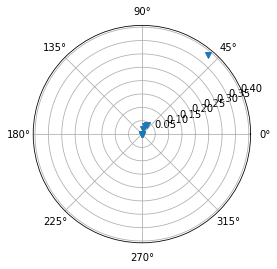

In [1132]:

plt.polar(x_rem,y_rem,'v')


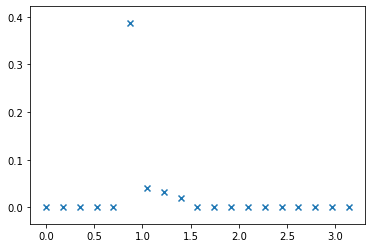

In [1135]:
import matplotlib.pyplot as plt


plt.scatter(x_rem, abs(np.array(y_rem)), marker = 'x')
plt.show()

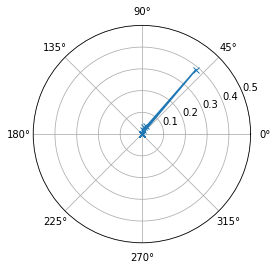

In [1136]:
import matplotlib.pyplot as plt

ax = plt.subplot(111, projection='polar')
ax.plot(x_rem, abs(np.array(y_rem)), marker = 'x')
ax.set_rmax(0.5)
ax.set_rmin(0)
plt.show()

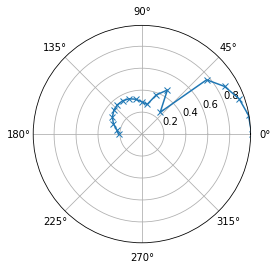

In [1137]:
import matplotlib.pyplot as plt

ax = plt.subplot(111, projection='polar')
ax.plot(x_rem_eb, abs(np.array(y_rem_eb)), marker = 'x')
ax.set_rmax(0.99)
ax.set_rmin(0)
plt.show()

In [1138]:
# experimental data
path='/home/vagner/Desktop/galfenol/galmrtheta.txt'
#path='/home/vagner/Desktop/galfenol/gal90deg.txt'
#path='/home/vagner/Desktop/galfenol/gal50deg.txt'
#path = '/home/vagner/Desktop/galfenol/gal0deg.txt'

hexp10ktube = open(path,'r')
hexp=hexp10ktube.readlines()

print(hexp[0])
#print(a1[0][1])

theta_on=[]
mexp_on=[]
hexp10ktube.close()
for i in range(len(hexp)):
    listexp=hexp[i].split('\t')
    theta_on.append(float(listexp[0]))
    mexp_on.append(float(listexp[1].split('\n')[0]))





0	935



In [1139]:
#mexp_on=np.array(mexp_on)/1214.
mexp_on=np.array(mexp_on)/1050.

In [1140]:
theta_on=np.array(theta_on)/180.0*3.1415

In [1141]:
mexp_on

array([0.89047619, 0.93761905, 0.98533333, 0.98095238, 0.96914286,
       0.96346667, 0.95428571, 0.81571429, 0.78338095, 0.67871429,
       0.70964762, 0.76548571, 0.79199048, 0.85672381, 0.87092381,
       0.88038095, 0.86684762, 0.8426    , 0.82254286])

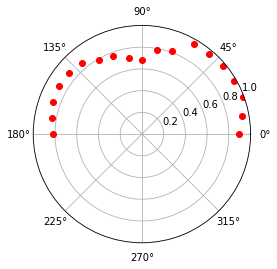

In [1142]:
plt.polar(theta_on,mexp_on,'ro')

In [1143]:
max(mexp_on)

0.9853333333333333

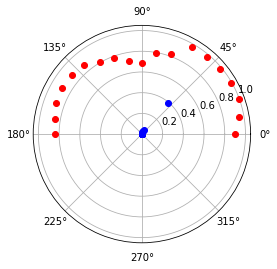

In [1144]:
plt.polar(theta_on,mexp_on/max(mexp_on),'ro')
#plt.polar(theta_on,mexp_on/1,'ro')
plt.polar(x_rem,np.array(y_rem)*1,'ro',color='b')


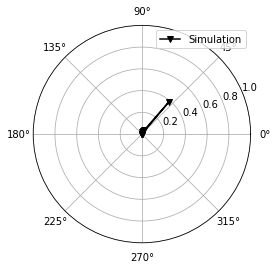

In [1145]:
import matplotlib.pyplot as plt

ax = plt.subplot(111, projection='polar')
l1=ax.plot(x_rem, abs(np.array(y_rem)), marker = 'v',color='black',label='Simulation')
#l2=ax.plot(theta_on, mexp_on/1, marker = 'o',color='red',label='Experimental')

#l2=ax.plot(theta_on, mexp_on/max(mexp_on), marker = 'o',color='red',label='Experimental')

ax.legend()
#plt.legend((l1,l2),('90 deg','50 deg'),fontsize=20)

ax.set_rmax(1.0)
ax.set_rmin(0)

# filme
#plt.savefig("polarplot_mr_intermoriyaquadratic")
#plt.savefig("polarplot_mr_interdipolar")
#plt.savefig("polarplot_mr_interexchange")
#plt.savefig("polarplot_mr_intermoriya")
#plt.savefig("polarplot_mr_intermoriyamultichiralspin")
#plt.savefig("polarplot_mr_interexchangebiquad")

# nanomembrane!
#plt.savefig("polarplot_mr_intermoriyamultichiralspin_nmb")
#plt.savefig("polarplot_mr_interdipolar_nmb")
#plt.savefig("polarplot_mr_interdipolar_nmb_longer")


plt.show()

In [954]:
hini

18.4

In [1270]:
Jeff_EB*Msat

3.769911184307752

In [1271]:
Kf1/Msat

3.7699111843077517

In [1272]:
import time
start=time.time()
#m_inter,h_inter,h_test,hnowlist = hysteresis_inter(NN2,Msat,hpasso)
divphi=8*18
phi_ini=-2*pi/2.
phi_final=2/2.*pi+0*3.1415/4.
phi_step=(phi_final-phi_ini)/divphi
hphi=phi_ini+0.00*pi/180

list_hc=[]
list_eb=[]
for l in tnrange(divphi+1):
#for l in tnrange(5):
    m_inter,h_inter,h_test,hnowlist = hysteresis_inter(NN2,Msat,hpasso,hphi)
    hc1,hc2=None,None
    for i in range(len(m_inter)):
#        if(m_inter[i]>0 and h_inter[i]>=0.0):
        if(m_inter[i]<0 and m_inter[i-1]>0):
            hc1=(h_inter[i-1]+h_inter[i])/2.
        if(m_inter[i]>0 and m_inter[i-1]<0):
            hc2=(h_inter[i-1]+h_inter[i])/2.
#            break
#    hc=h_inter[-1]
    hc=(hc1-hc2)/2.
    heb=(hc1+hc2)/2.
    print(hphi,hc)
    list_hc.append([hphi,hc])
    list_eb.append([hphi,heb])
    phi_ini+=phi_step
    hphi+=phi_step
    
    
list_hc=np.array(list_hc)
    
stop=time.time()
print(-start+stop)

/home/vagner/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


-3.141592653589793 -20.18683333333349
-3.097959422289935 -19.367833333333483
-3.0543261909900767 -18.38200000000014
-3.0106929596902186 -17.396166666666797
-2.9670597283903604 -17.259666666666796
-2.923426497090502 -15.940166666666787
-2.879793265790644 -15.424500000000114
-2.836160034490786 -14.999833333333445
-2.7925268031909276 -14.63583333333344
-2.7488935718910694 -14.378000000000107
-2.7052603405912112 -14.165666666666771
-2.661627109291353 -14.014000000000102
-2.617993877991495 -13.923000000000103
-2.5743606466916367 -13.892666666666768
-2.5307274153917785 -13.907833333333436
-2.4870941840919203 -13.968500000000102
-2.443460952792062 -14.105000000000103
-2.399827721492204 -14.302166666666771
-2.3561944901923457 -14.575166666666775
-2.3125612588924875 -14.954333333333445
-2.2689280275926293 -15.424500000000116
-2.225294796292771 -16.046333333333454
-2.181661564992913 -16.895666666666795
-2.138028333693055 -18.09383333333347
-2.0943951023931966 -19.716666666666818
-2.0507618710933

In [1273]:
hc2,phi_ini

(32.8358333333333, 3.1852258848896455)

In [1277]:
m_inter

array([0.96466872, 0.9644422 , 0.96421494, ..., 0.9644422 , 0.96466873,
       0.96489455])

In [1278]:
phi_step

0.04363323129985824

In [1279]:
hc

-20.18683333333349

In [1280]:
list_hc

array([[-3.14159265e+00, -2.01868333e+01],
       [-3.09795942e+00, -1.93678333e+01],
       [-3.05432619e+00, -1.83820000e+01],
       [-3.01069296e+00, -1.73961667e+01],
       [-2.96705973e+00, -1.72596667e+01],
       [-2.92342650e+00, -1.59401667e+01],
       [-2.87979327e+00, -1.54245000e+01],
       [-2.83616003e+00, -1.49998333e+01],
       [-2.79252680e+00, -1.46358333e+01],
       [-2.74889357e+00, -1.43780000e+01],
       [-2.70526034e+00, -1.41656667e+01],
       [-2.66162711e+00, -1.40140000e+01],
       [-2.61799388e+00, -1.39230000e+01],
       [-2.57436065e+00, -1.38926667e+01],
       [-2.53072742e+00, -1.39078333e+01],
       [-2.48709418e+00, -1.39685000e+01],
       [-2.44346095e+00, -1.41050000e+01],
       [-2.39982772e+00, -1.43021667e+01],
       [-2.35619449e+00, -1.45751667e+01],
       [-2.31256126e+00, -1.49543333e+01],
       [-2.26892803e+00, -1.54245000e+01],
       [-2.22529480e+00, -1.60463333e+01],
       [-2.18166156e+00, -1.68956667e+01],
       [-2.

In [1281]:
list_eb

[[-3.141592653589793, 12.648999999999809],
 [-3.097959422289935, 11.829999999999803],
 [-3.0543261909900767, 10.358833333333122],
 [-3.0106929596902186, 9.312333333333111],
 [-2.9670597283903604, 9.08483333333311],
 [-2.923426497090502, 7.674333333333099],
 [-2.879793265790644, 7.006999999999758],
 [-2.836160034490786, 6.430666666666419],
 [-2.7925268031909276, 5.914999999999747],
 [-2.7488935718910694, 5.444833333333079],
 [-2.7052603405912112, 4.989833333333076],
 [-2.661627109291353, 4.595499999999738],
 [-2.617993877991495, 4.201166666666401],
 [-2.5743606466916367, 3.8068333333330653],
 [-2.5307274153917785, 3.4276666666663944],
 [-2.4870941840919203, 3.033333333333058],
 [-2.443460952792062, 2.654166666666388],
 [-2.399827721492204, 2.214333333333051],
 [-2.3561944901923457, 1.7593333333330463],
 [-2.3125612588924875, 1.258833333333043],
 [-2.2689280275926293, 0.6673333333330369],
 [-2.225294796292771, -0.015166666666967643],
 [-2.181661564992913, -0.8948333333336436],
 [-2.13802

In [1282]:
x_hc=[]
y_hc=[]

for i in range(len(list_hc)):
    x_hc.append(list_hc[i][0])
    y_hc.append(list_hc[i][1])    
    
x_eb=[]
y_eb=[]

for i in range(len(list_eb)):
    x_eb.append(list_eb[i][0])
    y_eb.append(list_eb[i][1])    
    
    

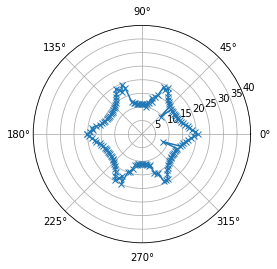

In [1283]:
import matplotlib.pyplot as plt

ax = plt.subplot(111, projection='polar')
ax.plot(x_hc, abs(np.array(y_hc)), marker = 'x')
#ax.scatter(x_hc, abs(np.array(y_hc)), marker = 'x')
ax.set_rmax(40)
ax.set_rmin(0)
plt.show()

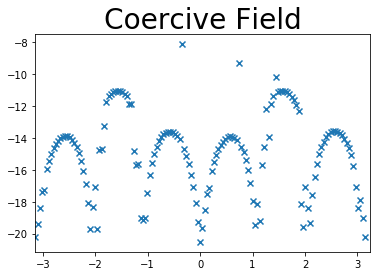

In [1284]:
import matplotlib.pyplot as plt

#plt.scatter(x_hc, abs(np.array(y_hc)), marker = 'x')
plt.scatter(x_hc, np.array(y_hc), marker = 'x')
plt.title("Coercive Field",size=28)
#ax.scatter(x_hc, abs(np.array(y_hc)), marker = 'x')
plt.xlim(-2/2*3.1415,2/2*3.1415+0.1)
plt.show()

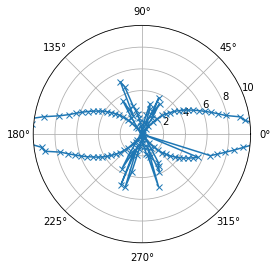

In [1286]:
import matplotlib.pyplot as plt

ax = plt.subplot(111, projection='polar')
ax.plot(x_eb, abs(np.array(y_eb)), marker = 'x')
ax.set_rmax(10)
ax.set_rmin(0)
plt.show()



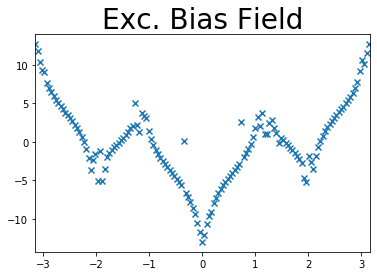

In [1287]:
import matplotlib.pyplot as plt

#plt.scatter(x_eb, abs(np.array(y_eb)), marker = 'x')
plt.scatter(x_eb, np.array(y_eb), marker = 'x')
#ax.scatter(x_hc, abs(np.array(y_hc)), marker = 'x')
plt.xlim(-2/2*3.1415,2/2*3.1415+0.02)
plt.title("Exc. Bias Field",size=28)
plt.show()

In [1048]:
# experimental data
path='/home/vagner/Desktop/galfenol/galhctheta.txt'
#path='/home/vagner/Desktop/galfenol/gal90deg.txt'
#path='/home/vagner/Desktop/galfenol/gal50deg.txt'
#path = '/home/vagner/Desktop/galfenol/gal0deg.txt'

hexp10ktube = open(path,'r')
hexp=hexp10ktube.readlines()

print(hexp[0])
#print(a1[0][1])

hc_on=[]
mexp_on=[]
hexp10ktube.close()
for i in range(len(hexp)):
    listexp=hexp[i].split('\t')
    hc_on.append(float(listexp[0]))
    mexp_on.append(float(listexp[1].split('\n')[0]))

theta_on=np.array(hc_on)
hc_on=np.array(mexp_on)



0	33.3



In [1049]:
theta_on=theta_on*3.1415/180.

In [1050]:
theta_on

array([0.        , 0.17452778, 0.34905556, 0.52358333, 0.69811111,
       0.87263889, 1.04716667, 1.22169444, 1.39622222, 1.57075   ,
       1.74527778, 1.91980556, 2.09433333, 2.26886111, 2.44338889,
       2.61791667, 2.79244444, 2.96697222, 3.1415    ])

In [1051]:
hc_on

array([33.3 , 31.03, 31.29, 31.74, 28.  , 27.73, 32.33, 20.81, 20.81,
       22.66, 20.97, 20.18, 29.93, 27.63, 27.44, 29.77, 30.04, 33.57,
       37.03])

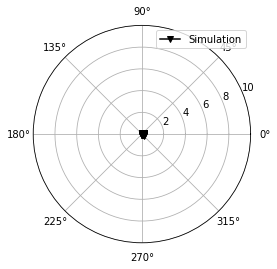

In [1053]:
import matplotlib.pyplot as plt

ax = plt.subplot(111, projection='polar')
l1=ax.plot(x_hc, abs(np.array(y_hc)), marker = 'v',color='black',label='Simulation')
#l2=ax.plot(theta_on, hc_on/1, marker = 'o',color='red',label='Experimental')

#l2=ax.plot(theta_on, mexp_on/1, marker = 'o',color='blue',label='Experimental')

ax.legend()
#plt.legend((l1,l2),('90 deg','50 deg'),fontsize=20)

ax.set_rmax(10)
ax.set_rmin(0)

# filme
#plt.savefig("polarplot_hc_cubic_moriyaquad.png")
#plt.savefig("polarplot_hc_cubic_dipolar.png")
#plt.savefig("polarplot_hc_cubic_exchange.png")
#plt.savefig("polarplot_hc_cubic_moriya.png")
#plt.savefig("polarplot_hc_cubic_moriyachiralmultispin.png")
#plt.savefig("polarplot_hc_cubic_exchangebiquad.png")

# nanomembrane!

#plt.savefig("polarplot_hc_cubic_moriyachiralmultispin_nmb.png")
#plt.savefig("polarplot_hc_cubic_dipolar_nmb.png")
#plt.savefig("polarplot_hc_cubic_dipolar_nmb_longer.png")

plt.show()

In [1299]:
m_inter,h_inter,h_test,hnowlist = hysteresis_inter(NN2,Msat,hpasso,0*3.1515/2.+5*pi/180)

In [1300]:
m_inter

array([0.99891527, 0.99891445, 0.99891364, ..., 0.99891445, 0.99891527,
       0.99891608])

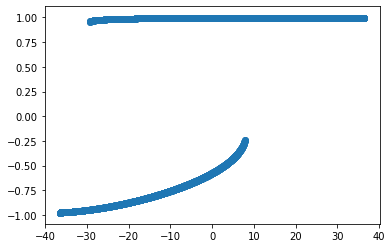

In [1301]:
import matplotlib.pyplot as plt
plt.scatter(h_inter,m_inter)
plt.show()

In [873]:
m_inter[step-1]

0.22657827623148954

In [874]:
vv=[]
vv1=np.array([2,3])
vv1=np.array([vv1])
#print(vv1)
zzz=np.array([[1,2],[4,5]])
#vv1=np.append(zzz,np.array([vv1]))
vv1=np.concatenate((zzz,vv1),axis=0)
vv1=np.concatenate((np.array([[3,23]]),vv1),axis=0)
print(vv1[0],len(vv1[0]))

[ 3 23] 2


In [875]:
desired_length = 50
resultsnew = np.empty(desired_length)
#print(resultsnew,len(maglist))

In [876]:
zzz

array([[1, 2],
       [4, 5]])

In [877]:
lis=[1,2,3]
zz=np.copy(lis)
zz
lis[0]=20
print(lis,zz)

[20, 2, 3] [1 2 3]


In [878]:
Msat
print(beta,hpasso)

0.0 -0.030333333333333334


In [879]:
print(start-stop)

2143.2099945545197


In [880]:
hnowlist[-1],hnowlist[0]

(36.46066666666666, 0.0)

In [881]:
h_inter[0],h_inter[-1]

(36.4, 36.46066666666666)

In [882]:
print(m_inter)
print(len(m_inter))

[0.78692922 0.78692776 0.7869263  ... 0.22655676 0.2265675  0.22657828]
2400


In [883]:
maglistend2=[]
for j in range(len(m_inter)):
    soma=0
    for i in range(len(m_inter[0])):
#        print(i)
        soma+=m_inter[j][i]
    maglistend2.append(soma/NN2)
        

TypeError: object of type 'numpy.float64' has no len()

In [884]:
print(maglistend2)
print(len(maglistend2))

[]
0


In [885]:
#h_test[8]


In [886]:
Kf1_bi/Msat

2.5132741228718345

In [887]:
Msat

79.57747154594767

In [888]:
hini

36.4

In [889]:
m_inter

array([0.78692922, 0.78692776, 0.7869263 , ..., 0.22655676, 0.2265675 ,
       0.22657828])

In [467]:
m_rot=np.array([-1 if(h_inter[i]<-20) else 1 for i in range(len(h_inter))])

In [468]:
m_rot

array([1, 1, 1, ..., 1, 1, 1])

In [469]:
h

-5.01

(-1, 1)

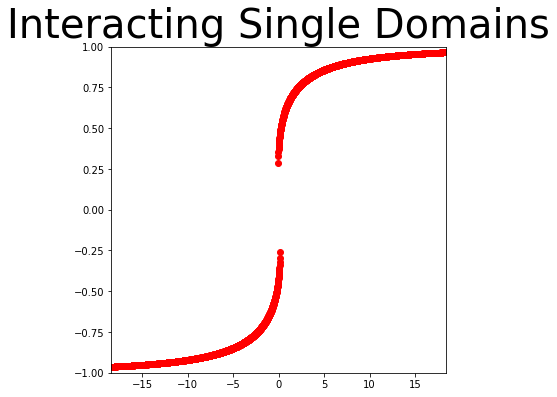

In [470]:
import matplotlib.pyplot as plt

norm=1.00

plt.figure(figsize=(6,6))

plt.title("Interacting Single Domains",size=40)

#plt.scatter(np.array(h_inter)[:int(len(h_inter)*2/2.)],np.array(m_inter)[:int(len(h_inter)*2/2.)]/norm,color='r')
plt.scatter(np.array(h_inter),(4/4*np.array(m_inter)+0/4*m_rot)/1./norm,color='r')
#plt.scatter(-np.array(h_inter),-np.array(m_inter)/norm,color='b')

#plt.scatter(hexp_on,np.array(mexp_on)/0.99)

#plt.xlim(-1600*3*3,1600*3*3)
plt.xlim(-abs(hini/1.),abs(hini/1.))
plt.ylim(-1,1)
#plt.savefig('firstsimul_20x20_interdipol_3D.jpeg')
#plt.savefig('firstsimul_20x20_nointer_3D.jpeg')
##plt.savefig('firstsimul_10x10_nointer.jpeg')
#plt.savefig('firstsimul_12x12_nointer_3D.jpeg')
#plt.savefig('firstsimul_12x12_interdipol_3D.jpeg')





In [894]:
hphi/pi

0.2638888888888888

In [164]:
# experimental data
#path='/home/vagner/Desktop/galfenol/gal90deg.txt'
#path='/home/vagner/Desktop/galfenol/gal50deg.txt'
path = '/home/vagner/Desktop/galfenol/gal0deg.txt'

hexp10ktube = open(path,'r')
hexp=hexp10ktube.readlines()

print(hexp[0])
#print(a1[0][1])

hexp_on=[]
mexp_on=[]
hexp10ktube.close()
for i in range(len(hexp)):
    listexp=hexp[i].split('\t')
    hexp_on.append(float(listexp[0]))
    mexp_on.append(float(listexp[1].split('\n')[0]))

9999.80078	1



In [1515]:
hexp_on[int(len(hexp_on)/4+4)]

0.93199

In [1516]:
mexp_on[int(len(hexp_on)/4+4)]

0.77165

In [1517]:
mexp_on=np.array(mexp_on)
hant=0
for i in range(len(hexp_on)):
    if(hexp_on[i]>-100 and hant<-100):
        h11_index=i
    if(hexp_on[i]>-200 and hant<-200):
        h22_index=i
    hant=hexp_on[i]


In [1518]:
h11_index
h22_index

1570

In [2873]:
hexp_on[h22_index]-hexp_on[h11_index]

-100.1131

In [2874]:
mexp_on[h22_index]

-0.89326

In [2875]:
mexp_on[h22_index]-mexp_on[h11_index]

-0.09305000000000008

In [2876]:
(mexp_on[h22_index]-mexp_on[h11_index])/(hexp_on[h22_index]-hexp_on[h11_index])*np.array(hexp_on)

array([9.29422245, 9.27334661, 9.26227491, ..., 9.26513541, 9.28456489,
       9.29425285])

In [2877]:
mexp_on=mexp_on-(mexp_on[h22_index]-mexp_on[h11_index])/(hexp_on[h22_index]-hexp_on[h11_index])*np.array(hexp_on)

In [2878]:
norm=abs(mexp_on[h11_index])

In [2879]:
mexp_on=mexp_on/norm

In [4680]:
# experimental data
path1='/home/vagner/Desktop/galfenol/gal90deg.txt'
path2='/home/vagner/Desktop/galfenol/gal50deg.txt'
path3 = '/home/vagner/Desktop/galfenol/gal0deg.txt'

hexp10ktube = open(path1,'r')
hexp=hexp10ktube.readlines()


hexp_on1=[]
mexp_on1=[]
hexp10ktube.close()
for i in range(len(hexp)):
    listexp=hexp[i].split('\t')
    hexp_on1.append(float(listexp[0]))
    mexp_on1.append(float(listexp[1].split('\n')[0]))

hexp10ktube = open(path2,'r')
hexp=hexp10ktube.readlines()


hexp_on2=[]
mexp_on2=[]
hexp10ktube.close()
for i in range(len(hexp)):
    listexp=hexp[i].split('\t')
    hexp_on2.append(float(listexp[0]))
    mexp_on2.append(float(listexp[1].split('\n')[0]))
        
    
hexp10ktube = open(path3,'r')
hexp=hexp10ktube.readlines()


hexp_on3=[]
mexp_on3=[]
hexp10ktube.close()
for i in range(len(hexp)):
    listexp=hexp[i].split('\t')
    hexp_on3.append(float(listexp[0]))
    mexp_on3.append(float(listexp[1].split('\n')[0]))
        

In [4689]:
mexp_on1=np.array(mexp_on1)
hant=0
for i in range(len(hexp_on1)):
    if(hexp_on1[i]>-100 and hant<-100):
        h11_index=i
    if(hexp_on1[i]>-200 and hant<-200):
        h22_index=i
    hant=hexp_on1[i]

mexp_on1=mexp_on1-(mexp_on1[h22_index]-mexp_on1[h11_index])/(hexp_on1[h22_index]-hexp_on1[h11_index])*np.array(hexp_on1)    
norm=abs(mexp_on1[h11_index])
mexp_on1=mexp_on1/norm


In [4682]:
mexp_on2=np.array(mexp_on2)
hant=0
for i in range(len(hexp_on2)):
    if(hexp_on2[i]>-100 and hant<-100):
        h11_index=i
    if(hexp_on2[i]>-200 and hant<-200):
        h22_index=i
    hant=hexp_on2[i]

mexp_on2=mexp_on2-(mexp_on2[h22_index]-mexp_on2[h11_index])/(hexp_on2[h22_index]-hexp_on2[h11_index])*np.array(hexp_on2)    
norm=abs(mexp_on2[h11_index])
mexp_on2=mexp_on2/norm


In [4683]:
mexp_on3=np.array(mexp_on3)
hant=0
for i in range(len(hexp_on3)):
    if(hexp_on3[i]>-100 and hant<-100):
        h11_index=i
    if(hexp_on3[i]>-200 and hant<-200):
        h22_index=i
    hant=hexp_on3[i]

mexp_on3=mexp_on3-(mexp_on3[h22_index]-mexp_on3[h11_index])/(hexp_on3[h22_index]-hexp_on3[h11_index])*np.array(hexp_on3)    
norm=abs(mexp_on3[h11_index])
mexp_on3=mexp_on3/norm


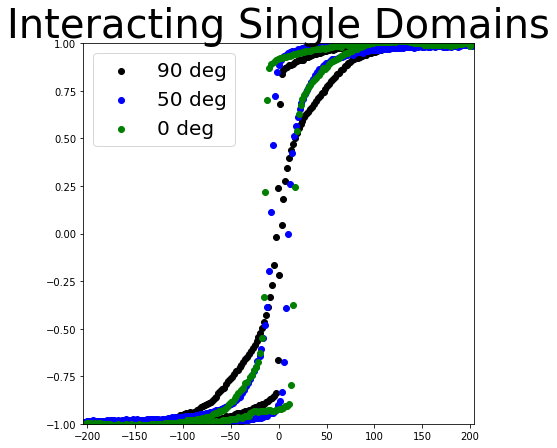

In [4690]:
import matplotlib.pyplot as plt

norm=1.00

plt.figure(figsize=(7,7))

plt.title("Interacting Single Domains",size=40)

l1=plt.scatter(hexp_on1,np.array(mexp_on1),color='black',label='90 deg')
l2=plt.scatter(hexp_on2,np.array(mexp_on2),color='blue',label='50 deg')
l3=plt.scatter(hexp_on3,np.array(mexp_on3),color='green',label='0 deg')

plt.legend((l1,l2,l3),('90 deg','50 deg','0 deg'),fontsize=20)

#plt.xlim(-1600*3*3,1600*3*3)
plt.xlim(-abs(hini/1.),abs(hini/1.))
plt.ylim(-1,1)
#plt.savefig('firstsimul_20x20_interdipol_3D.jpeg')
#plt.savefig('firstsimul_20x20_nointer_3D.jpeg')
##plt.savefig('firstsimul_10x10_nointer.jpeg')
#plt.savefig('firstsimul_12x12_nointer_3D.jpeg')
#plt.savefig('firstsimul_12x12_interdipol_3D.jpeg')

plt.show()




In [ ]:
path = '/home/vagner/Desktop/RolledupNanomembranes/python3/data_tube_10K_perptubeaxis_h.dat'
#path = '/home/vagner/Desktop/RolledupNanomembranes/python3/data_tube_10K_alongtubeaxis_h.dat'

hexp10ktube = open(path,'r')
hexp=hexp10ktube.readlines()

print(hexp[0])
#print(a1[0][1])

hexp10ktube.close()

#hexp = [float(i) for i in hexp]


path = '/home/vagner/Desktop/RolledupNanomembranes/python3/data_tube_10K_perptubeaxis_m.dat'
#path = '/home/vagner/Desktop/RolledupNanomembranes/python3/data_tube_10K_alongtubeaxis_m.dat'
mexp10ktube = open(path,'r')
mexp=mexp10ktube.readlines()

print(mexp[0])
#print(a1[0][1])

mexp10ktube.close()

#mexp = [float(i)*1.00 for i in mexp]
hexp_on=[]
mexp_on=[]
hexp10ktube.close()
for i in range(1,len(hexp)):
#    listexp=hexp[i].split('\t')
#    hexp_on.append(float(listexp[0]))
#    mexp_on.append(float(listexp[1].split('\n')[0]))
#    print(hexp[i],'e',i)
    hexp_on.append(float(hexp[i]))
    mexp_on.append(float(mexp[i]))    

In [ ]:
mexp_on

In [ ]:
stepmag

In [ ]:
coefmag